### Import libraries

In [ ]:
# Import needed libraries
# !pip install opencv-contrib-python==3.3.1.11
from skimage import io
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
from IPython.display import Markdown, display, HTML
import scipy
from tqdm import trange
%matplotlib inline

### Compute Panorama Image from Flat Input Images

Method:

We make use of the SIFT algorithm to extract keypoints of the two respective images (at a time). Following which, the keypoint matches are used to compute the Homography matrix that will be used to transform the second image to the perspective of the first, and the two are stitched together to form a partial panorama. The process is repeated for as many input there are. The helper function below computes this while the main function processes the list of input image to achieve a 'fish-eye' pan from the left to the right for better visualization. 

In [12]:
# Helper function to compute panorama image
def homography_ransac_helper(images, mode='path', flip=False):
    '''
    Input:
        images [int]: list of images
        mode: 'path' if using list of paths, else a list of loaded images
        flip: True if images should be flipped to be computed from the other side
    Output:
        results: resulting image
    Method:
        Loop through the image list and calculate homography matrix by comparing
        all the images before with the next image in the list
    '''
    
    # Initialize
    sift = cv.xfeatures2d.SIFT_create()
    img1 = images[0]
    if mode == 'path':
        img1 = cv.imread(img1)
        dx, dy = 1500, 800 #size of window
    else:
        dx, dy = 4000, 1000 #size of final window
    if flip:
        img1 = cv.flip(img1,1)
        
    # Loop through image list
    for idx in trange(len(images)-1):
        img2 = images[idx+1]
        if mode == 'path':
            img2 = cv.imread(img2)
        if flip:
            img2 = cv.flip(img2,1)
            
        # Compute keypoints + Descriptors
        kp1, desc1 = sift.detectAndCompute(img1, None)
        kp2, desc2 = sift.detectAndCompute(img2, None)
        
        # Use BFMatcher object to match up the SIFT features using Euclidean distance
        bf = cv.BFMatcher(cv.NORM_L2, crossCheck=True)
        matches = bf.match(desc1, desc2)
        matches = sorted(matches, key = lambda x:x.distance)
        
        # Extract location of good matches
        points1 = np.zeros((len(matches), 2), dtype=np.float32)
        points2 = np.zeros((len(matches), 2), dtype=np.float32)
        for i, match in enumerate(matches):
            points1[i, :] = kp1[match.queryIdx].pt
            points2[i, :] = kp2[match.trainIdx].pt
            
        # Calculate homography matrix and transform image
        H, _ = cv.findHomography(points2, points1, cv.RANSAC)
        reformed = cv.warpPerspective(img2, H, (dx, dy))
        img1 = cv.warpPerspective(img1, np.identity(3), (reformed.shape[1], reformed.shape[0]))
        results = cv.addWeighted(reformed, 0.7, img1, 0.5, 0.9)
        
        # Balance out intensity for result image
        for i in range(reformed.shape[0]):
            for j in range(reformed.shape[1]):
                if sum(reformed[i][j]) == 0 :
                    results[i][j] = img1[i][j]
                elif sum(img1[i][j]) == 0 :
                    results[i][j] = reformed[i][j]
        
        # Increment for next loop
        dx += 700
        dy += 200
        img1 = results

    if flip:
        return cv.flip(results,1)
    return results
    
# Main function to process images from two ends to achieve fish-eye effect
def homography_ransac_multi(crop_x1, crop_x2, crop_y1, crop_y2, *args):
    '''
    Input:
        crop_x1, crop_x2, crop_y1, crop_y2: cropping window
        args: multiple image 
    Output:
        visualization of panorama
    Method:
        1. Split images into two list, sharing one image (for easier mapping at the end)
        2. Flip the first half vertically and compute (so that its resulting image pans to the left)
        3. Compute the right half (pans to the right)
        4. Combine the left and right to create resulting image with fish-eye effect
    '''
    
    # Split images into two arrays:
    images = list(args)
    images1 = images[:round(len(images)/2)+1][::-1] #first half
    images2 = images[round(len(images)/2):] #second half
    
    # Compute first and second half (pans to the left/right respectively)
    image1 = homography_ransac_helper(images1, flip=True)
    image2 = homography_ransac_helper(images2)
    
    # Combine first and second half
    result = homography_ransac_helper([image1, image2], mode='image')
    
    # Visualize
    fig = plt.figure(figsize=(50,20))
    result = result[crop_x1:crop_x2,crop_y1:crop_y2]
    io.imshow(cv.cvtColor(result, cv.COLOR_BGR2RGB))


### Show Original Images

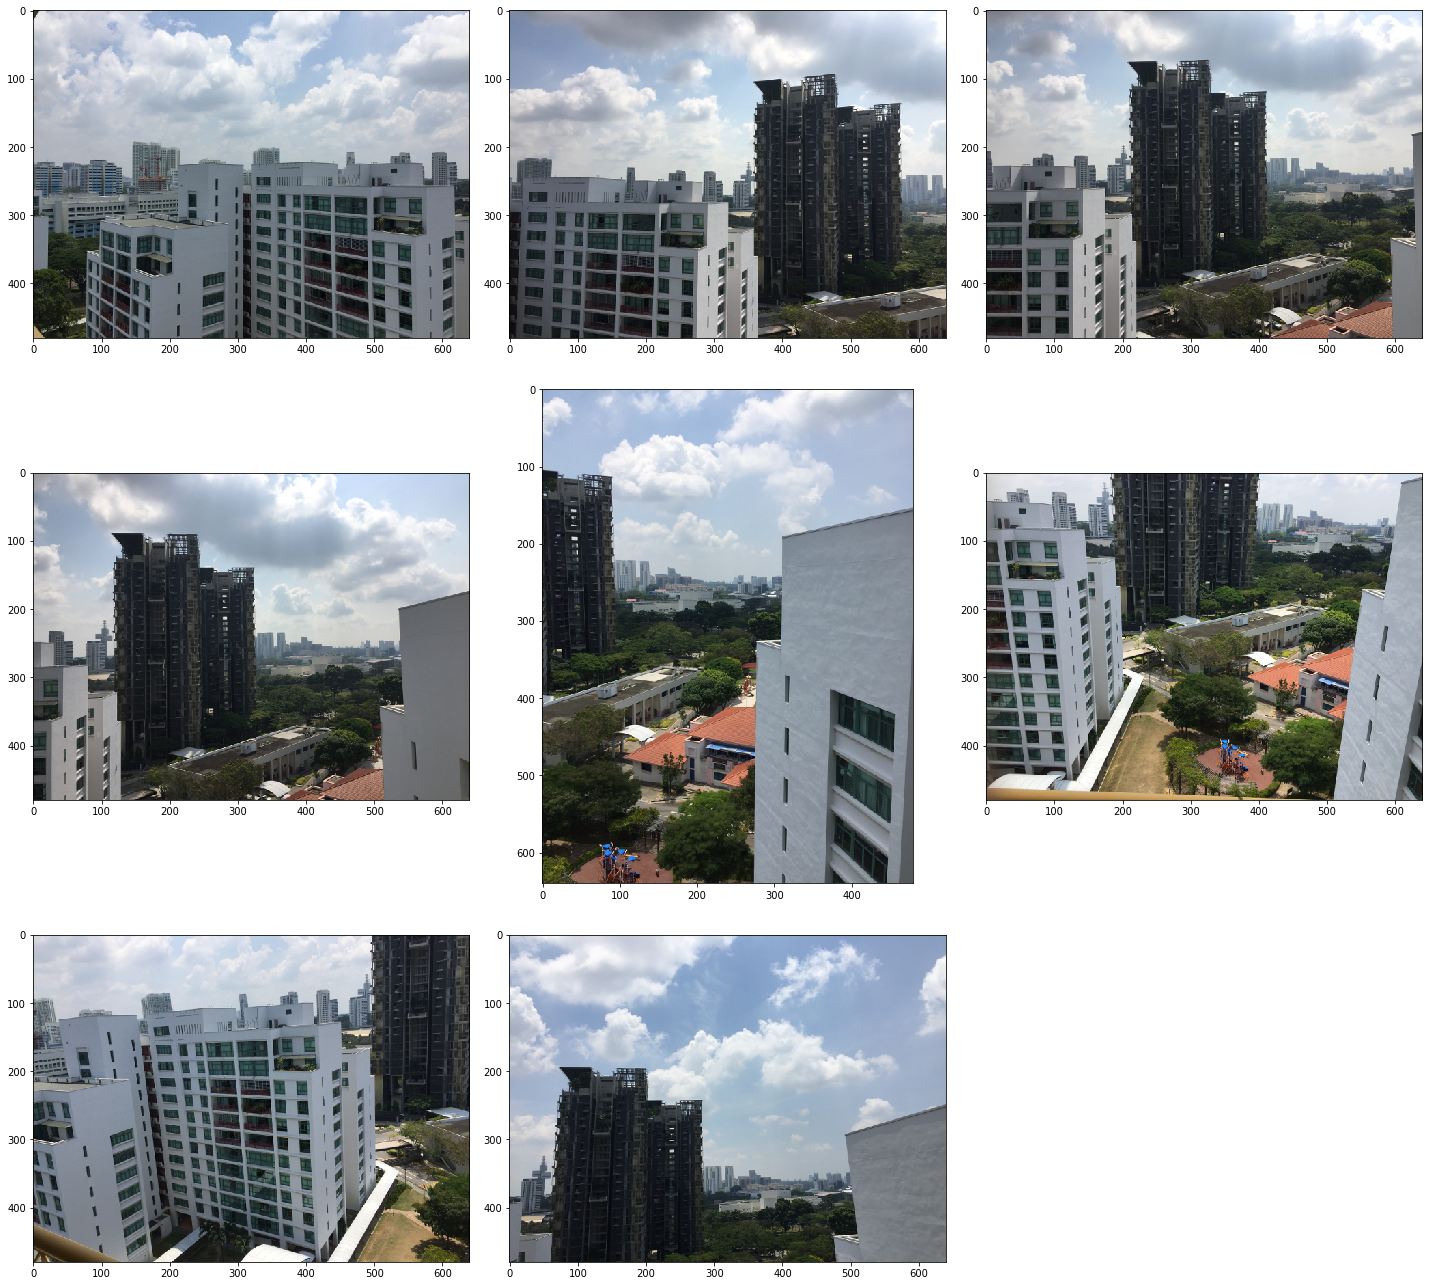

In [20]:
fig = plt.figure(figsize=(20,20))
fig.add_subplot(331)
io.imshow(cv.cvtColor(cv.imread('im01.jpg'), cv.COLOR_BGR2RGB))
fig.add_subplot(332)
io.imshow(cv.cvtColor(cv.imread('im02.jpg'), cv.COLOR_BGR2RGB))
fig.add_subplot(333)
io.imshow(cv.cvtColor(cv.imread('im03.jpg'), cv.COLOR_BGR2RGB))
fig.add_subplot(334)
io.imshow(cv.cvtColor(cv.imread('im04.jpg'), cv.COLOR_BGR2RGB))
fig.add_subplot(335)
io.imshow(cv.cvtColor(cv.imread('im05.jpg'), cv.COLOR_BGR2RGB))
fig.add_subplot(336)
io.imshow(cv.cvtColor(cv.imread('im06.jpg'), cv.COLOR_BGR2RGB))
fig.add_subplot(337)
io.imshow(cv.cvtColor(cv.imread('im07.jpg'), cv.COLOR_BGR2RGB))
fig.add_subplot(338)
io.imshow(cv.cvtColor(cv.imread('im08.jpg'), cv.COLOR_BGR2RGB))

### Display Panorama

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:29<00:00, 29.78s/it]


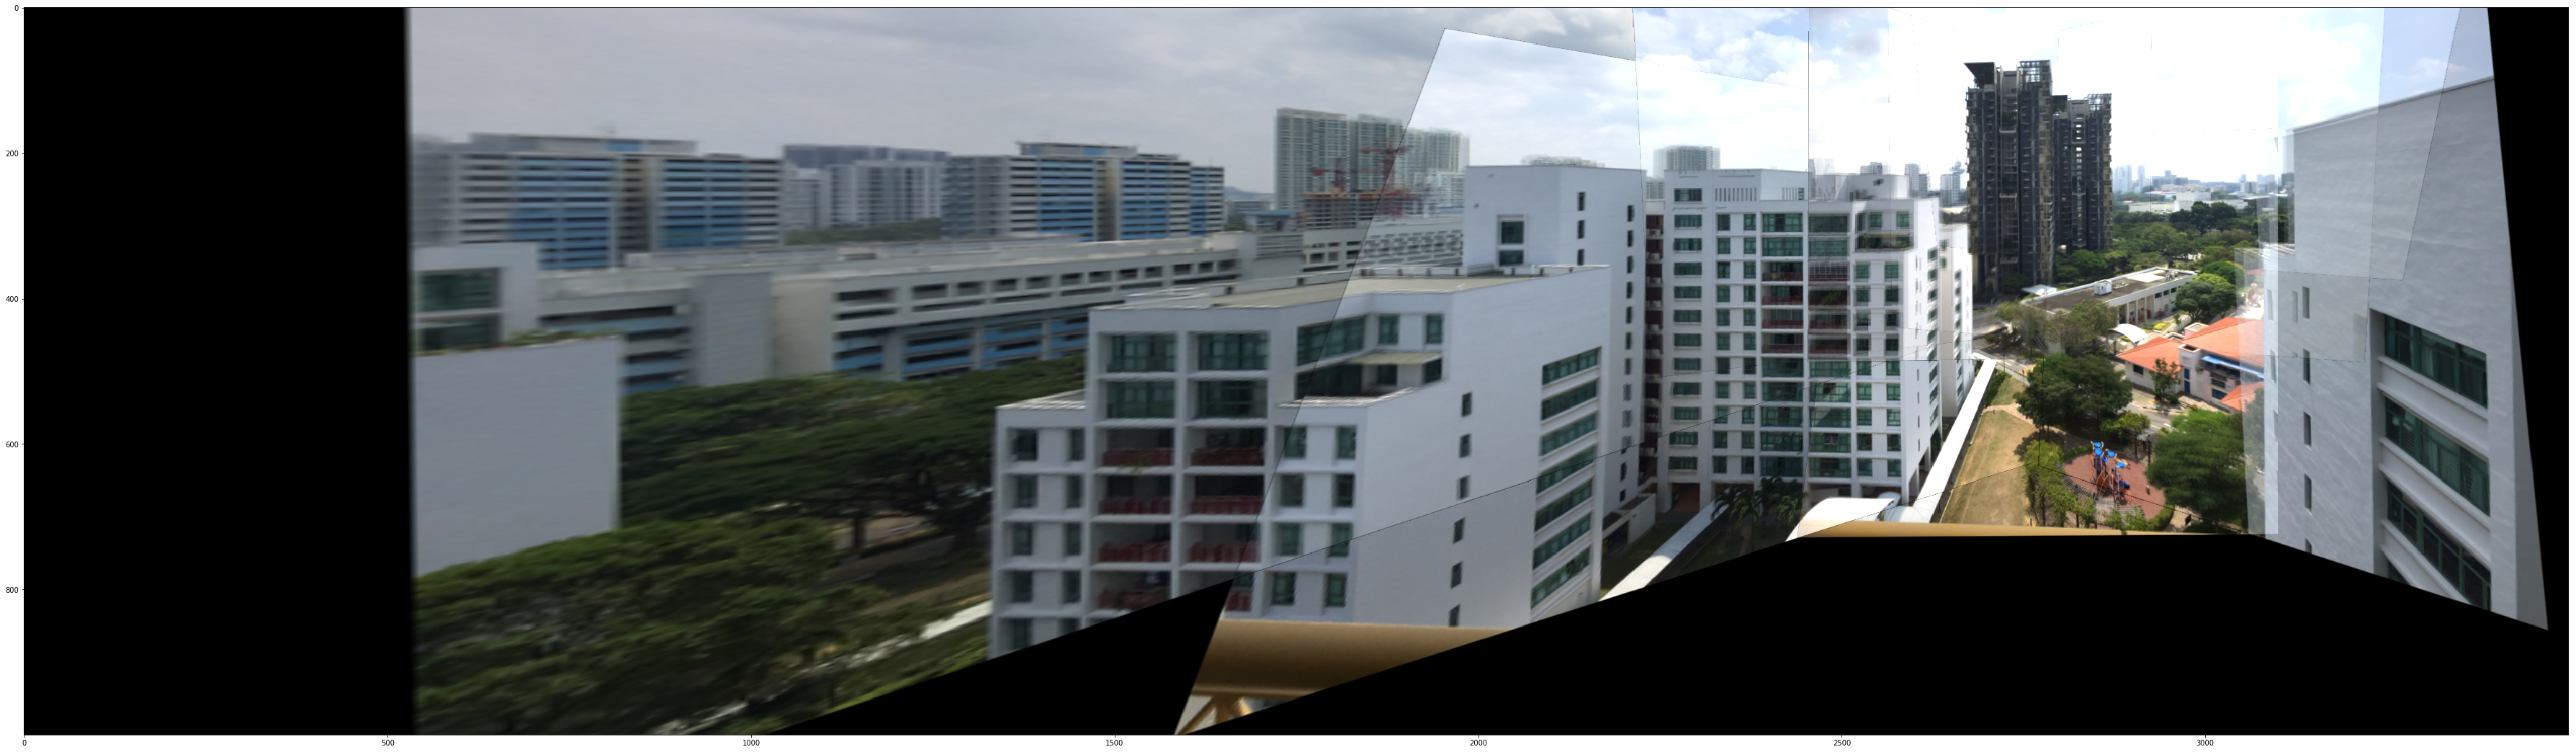

In [18]:
# 8 images blended to form 1 panorama
# Possible to do more but the rest of the images don't provide more breadth so it won't expand the scope
homography_ransac_multi(0,1000,500,4000, 'im01.jpg','im02.jpg','im07.jpg','im06.jpg','im03.jpg','im04.jpg','im08.jpg','im05.jpg')

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:33<00:00, 33.71s/it]


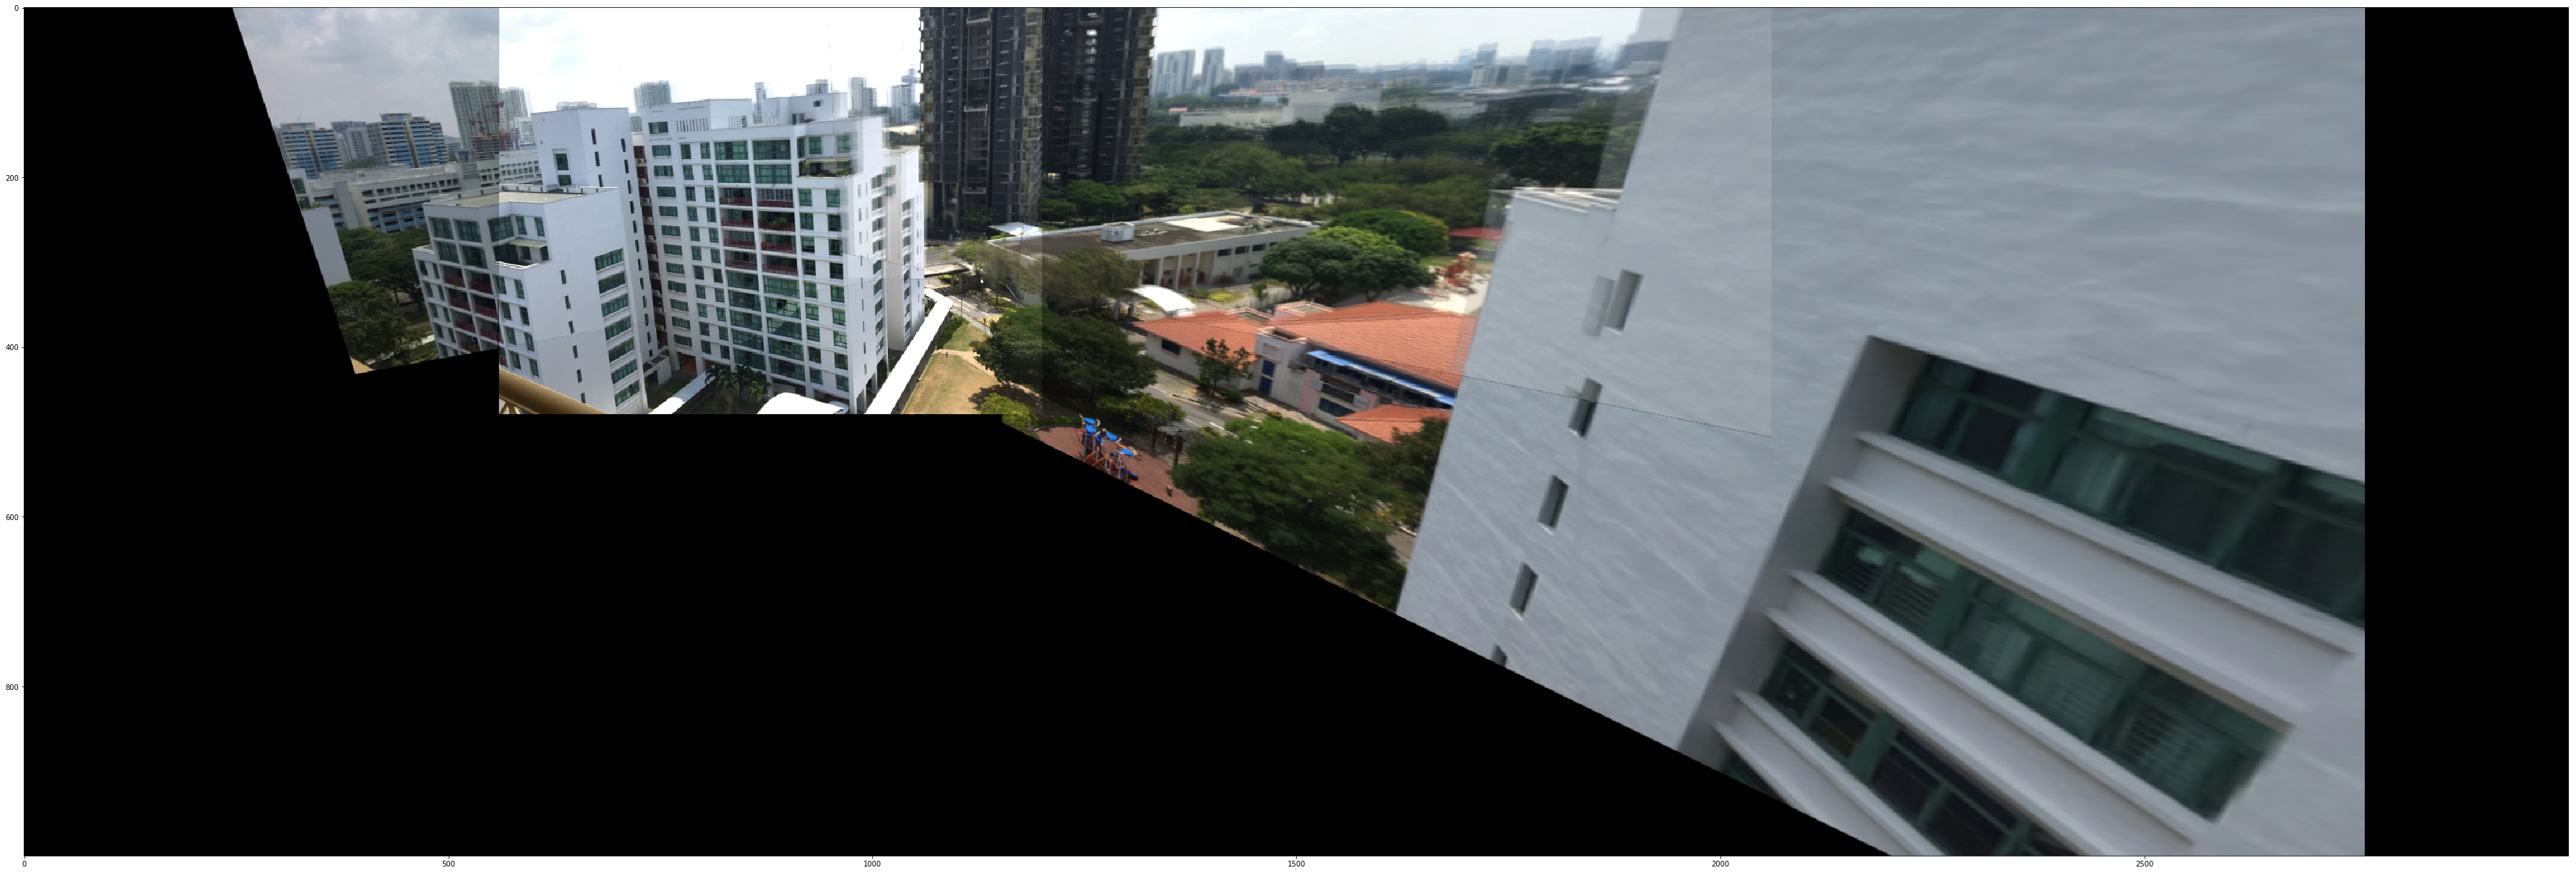

In [14]:
# Panorama of 5 images (changes the angle of view)
homography_ransac_multi(0,1000,1000,4000, 'im01.jpg','im02.jpg','im07.jpg','im04.jpg', 'im05.jpg')

### Additional: Manual Computation of Homography Matrix with Clicked-on Coordinates

Method:

Use Tkinter to scan in clicked on coordinates to compute the homography matrix with the first 4 points (closed form, but can use more for more robust solution). The more the coordinates resemble its counterpart, the better the results.

In [ ]:
from tkinter import *
from PIL import ImageTk, Image

# Function to select coordinates
def get_coord(path):
    '''
    Input: 
        file path name
    Output:
        list of 4 coordinates that is clicked on
    Method:
        Triggers 2 pop up window for user to click on 4 coordinates (if >4, only first 4 selected)
    '''
    
    # Helper function to record clicked coordinates
    def printcoords(event):
        coords.append((event.x, event.y))
        
    # Set up a tkinter canvas with scrollbars
    coords = []
    root = Tk()
    root.geometry("%dx%d" % (1000, 1000))
    frame = Frame(root, bd=2, relief=SUNKEN)
    frame.grid_rowconfigure(0, weight=1)
    frame.grid_columnconfigure(0, weight=1)
    canvas = Canvas(frame)
    canvas.grid(row=0, column=0, sticky=N+S+E+W)
    frame.pack(fill=BOTH,expand=1)

    # Include Image
    img = ImageTk.PhotoImage(file=path)
    canvas.create_image(100, 100, anchor=NE, image=img)
    canvas.config(scrollregion=canvas.bbox(ALL))

    # Create function to take in clicked coordinate
    canvas.bind("<ButtonPress-1>",printcoords)
    root.mainloop()

    return coords[:4]

# Function to calculate homography matrix
def homography_manual(coords1, coords2):
    '''
    Input:
        Two lists containing 4 tuples of chosen x-y coordinates
    Output:
        Numpy matrix
    Method:
        Uses singular value decomposition to get 
    '''
    matrix = []
    for i in range(4):
        x,y = coords1[i][0], coords1[i][1]
        xp,yp = coords2[i][0], coords2[i][1]
        matrix.extend([x,y,1,0,0,0,-xp*x,-xp*y,-xp])
        matrix.extend([0,0,0,x,y,1,-yp*x,-yp*y,-yp])
        
    matrix = np.reshape(matrix, (8,9))
    u, s, vt = np.linalg.svd(matrix)
    return np.reshape(vt[-1]/vt[-1][-1], (3,3))